# MD Analysis Tomás Frazão

**Last update: 17th October 2022**


some qualitative studies on the MD convergence/sampling quality are performed in this notebook. 
Also a distance is monitored along the simulation.

Concretely:
NOTE: you do not need to load an aligned trajectory as this will be done here.
IMPORTANT: Update SELECTIONS of atoms for fittings according to your system


### How to use this notebook


1. You have to run the cell containing the dependencies imports before starting to run the code. An easy way to have all_loop these dependencies install_looped is to create a conda environment with:

`conda create -n md_analysis -c anaconda -c conda-forge -c ambermd jupyter pytraj mdtraj matplotlib scikit-learn`


### Dependencies of this notebook
* matplotlib (-c conda-forge)
* pytraj (-c ambermd)
* scikit-learn (-c anaconda)
* mdtraj

In [2]:
%matplotlib inline
import pandas as pd
import pytraj as pt
import numpy as np
import math
import matplotlib.pyplot as plt
# we will also use mdtraj
import mdtraj as md
from mdtraj.testing import get_fn
#
from sklearn.decomposition import PCA
import time

## Concept of convergence
"From our point of view and for our scope, a MD trajectory is considered converged when a full exploration of the conformational space is achieved. In particular, a stable conformation or a pull of relative stable conformations visited for a statistically consistent number of times is considered a convergence indicator."

"From this statistical point of view **is not possible to describe if a simulation is absolutely converged** [1]. However, there are several methods in the literature that trough **qualitative and visual analyses** can quickly suggest that the simulation has not run enough and can help **to achieve a good sampling quality**."

## 0. Selection of atoms object of study
Before starting the convergence analyses, the first thing is to define which part of the system will be object of study. 

Typically, very flexible parts such as terminal residues are avoided, and representative atoms of the backbone like alpha carbons are selected.

#### 0.1 Load the trajectory and topology files
Different possibilities are given (some commented) depending on the format of the trajectory files.
Possibilities if the MDs are loaded with pytraj:(basically amber formats)

http://amber-md.github.io/pytraj/latest/read_and_write.html

If the MDs are loaded with mdtraj, we have more possibilities, including xtc (gromacs) +pdb for topology, or a pdb traj.
http://mdtraj.org/1.6.2/load_functions.html#the-trajectory-object

We indicate also the length of the trajectory in ns only for correct axis labels in plots.

In [3]:
TRAJECTORY_I = 'I/sys-fad-600ns-nowat.dcd'
TOPOLOGY_I = 'I/sys-fad-nowat.prmtop'
TRAJECTORY_I_rep = 'I_rep/sys-fad-600ns-nowat-rep.dcd' 
TOPOLOGY_I_rep = 'I_rep/sys-fad-nowat.prmtop'
TRAJECTORY_II = 'II/AsP2Ox-Closed-C2_autoprep_validated_mini-600ns-nowat.dcd'  
TOPOLOGY_II = 'II/AsP2Ox-Closed-C2_autoprep_validated_mini_nowat.prmtop'
TRAJECTORY_II_rep = 'II_rep/AsP2Ox-Closed-C2_autoprep_validated_mini-600ns-nowat.dcd'  
TOPOLOGY_II_rep = 'II_rep/AsP2Ox-Closed-C2_autoprep_validated_mini-nowat.prmtop'
TRAJECTORY_III = 'III_rep2/AsP2Ox-Open-glc-C2-100nsLastFrame200ns-nowat.dcd'  
TOPOLOGY_III = 'III_rep2/AsP2Ox-Open-glc-C2-100nsLastFrame_nowat.prmtop'
TRAJECTORY_III_rep = 'III_rep/sys-glc-fad-rep-200ns-nowat.dcd'  
TOPOLOGY_III_rep = 'III_rep/sys-glc-fad-nowat.prmtop'
TRAJECTORY_IV = 'IV/gamd-600ns-nowat-minus-glc.dcd' #it's actually system III without glucose (open glc)
TOPOLOGY_IV = 'IV/sys-minus-glc-fad-nowat.prmtop'
TRAJECTORY_IV_rep = 'IV_rep/gamd-600ns-nowat-minus-glc-rep.dcd'
TOPOLOGY_IV_rep = 'IV_rep/sys-minus-glc-fad-nowat.prmtop'

TRAJECTORY_LENGTH = 600 #Length of the trajectory in ns (for correct axis labels in plots)

In [4]:
traj_I = pt.iterload(TRAJECTORY_I, TOPOLOGY_I,frame_slice=(0, 62600,50))
#traj_I = traj_I[:]

In [5]:
traj_I_rep = pt.iterload(TRAJECTORY_I_rep, TOPOLOGY_I_rep, frame_slice=(0, 62600,50))
#traj_I_rep = traj_I_rep[:]

In [6]:
traj_II = pt.iterload(TRAJECTORY_II, TOPOLOGY_II, frame_slice=(0, 62600,50))
#traj_II = traj_II[:]

In [7]:
traj_II_rep = pt.iterload(TRAJECTORY_II_rep, TOPOLOGY_II_rep, frame_slice=(0, 62600,50))
#traj_II_rep = traj_II_rep[:]

In [8]:
traj_III = pt.iterload(TRAJECTORY_III, TOPOLOGY_III, frame_slice=(0, 22600,30))
#traj_III = traj_III[:]

In [9]:
traj_III_rep = pt.iterload(TRAJECTORY_III_rep, TOPOLOGY_III_rep, frame_slice=(0, 22600,30))
#traj_III_rep = traj_III_rep[:]

In [10]:
traj_IV = pt.iterload(TRAJECTORY_IV, TOPOLOGY_IV, frame_slice=(0, 62600,50))
#traj_IV = traj_IV[:]

In [11]:
traj_IV_rep = pt.iterload(TRAJECTORY_IV_rep, TOPOLOGY_IV_rep, frame_slice=(0, 62600,50))
#traj_IV_rep = traj_IV_rep[:]

In [12]:
print(traj_I)
print(traj_III)
print(traj_I_rep)
print(traj_II)
print(traj_II_rep)
print(traj_III_rep)
print(traj_IV)
print(traj_IV_rep)

pytraj.TrajectoryIterator, 1252 frames: 
Size: 0.211982 (GB)
<Topology: 7575 atoms, 508 residues, 2 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 754 frames: 
Size: 0.127596 (GB)
<Topology: 7571 atoms, 508 residues, 3 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 1252 frames: 
Size: 0.211982 (GB)
<Topology: 7575 atoms, 508 residues, 2 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 1252 frames: 
Size: 0.212653 (GB)
<Topology: 7599 atoms, 510 residues, 3 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 1252 frames: 
Size: 0.212653 (GB)
<Topology: 7599 atoms, 510 residues, 3 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 754 frames: 
Size: 0.127596 (GB)
<Topology: 7571 atoms, 508 residues, 3 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 1252 frames: 
Size: 0.211198 (GB)
<Topology: 7547 atoms, 506 residues, 2 mols, PBC with box type = ortho>

#### 0.2 Select the atoms that will be object of the study and align core
We use the notation of pytraj to select the atoms:

https://amber-md.github.io/pytraj/latest/atom_mask_selection.html


In [13]:
# This can be used for initial fitting. Corresponds to core except flexible loop and terminal of MCoA
#ref_SELECTION = '!(:1-6)&!(:285-313)&(@CA)'
ref_SELECTION = ":5-509@CA"

# This corresponds to all Ca (including loop) except flexible terminal. Used for RMSD.
SELECTION = ':5-509@CA'


Now the initial tajectory will be aligned. So no need to load aligned trajectory. 

In [14]:
trajectory_I = pt.align(traj_I, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_II = pt.align(traj_II, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_III = pt.align(traj_III, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_IV = pt.align(traj_IV, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_I_rep = pt.align(traj_I_rep, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_II_rep = pt.align(traj_II_rep, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_III_rep = pt.align(traj_III_rep, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_IV_rep = pt.align(traj_IV_rep, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)


## 1. RMSD from the first frame
- If the plot does not reach a steady state (meaning on that may fluctuate significantly, but has no significant trend), the system is clearly not converged. [1]
- It is of limited utility, because it contains little information about what states are being sampled. [1]
- It should be considered as an equilibration test, starting the "production part" of the MD when the RMSD achieves a plateau after the curve has increased rapidly at the begining. This "equilibration" part should be discarded in further production analyses. [2]

Calculate RMSD of all frames with respect to the first frame

In [14]:
rmsd_I = pt.analysis.rmsd.rmsd(traj=traj_I, mask=SELECTION, ref=0, update_coordinate=False,nofit=True)  #NoFit because I aligned before only core
rmsd_II = pt.analysis.rmsd.rmsd(traj=traj_II, mask=SELECTION, ref=0, update_coordinate=False,nofit=True)
rmsd_III = pt.analysis.rmsd.rmsd(traj=traj_III, mask=SELECTION, ref=0, update_coordinate=False,nofit=True)
rmsd_IV = pt.analysis.rmsd.rmsd(traj=traj_IV, mask=SELECTION, ref=0, update_coordinate=False,nofit=True)
rmsd_I_rep = pt.analysis.rmsd.rmsd(traj=traj_I_rep, mask=SELECTION, ref=0, update_coordinate=False,nofit=True)  #NoFit because I aligned before only core
rmsd_II_rep = pt.analysis.rmsd.rmsd(traj=traj_II_rep, mask=SELECTION, ref=0, update_coordinate=False,nofit=True)
rmsd_III_rep = pt.analysis.rmsd.rmsd(traj=traj_III_rep, mask=SELECTION, ref=0, update_coordinate=False,nofit=True)
rmsd_IV_rep = pt.analysis.rmsd.rmsd(traj=traj_IV_rep, mask=SELECTION, ref=0, update_coordinate=False,nofit=True)

print(len(rmsd_I))
print(len(rmsd_II))
print(len(rmsd_III))
print(len(rmsd_IV))
print(len(rmsd_I_rep))
print(len(rmsd_II_rep))
print(len(rmsd_III_rep))
print(len(rmsd_IV_rep))


#print(rmsd_III[2000])

1252
1252
754
1252
1252
1252
754
1252


Plot the data

In [15]:
RMSD_PLOT_FILENAME = './AsP2Ox_MD_RMSD.png' #Output filename for the plot

RMSD_COLOR = 'forestgreen' #Color of the line
MAX_Y = math.ceil(rmsd_I.max()) #It can be modified if you want to change the scale of the plot

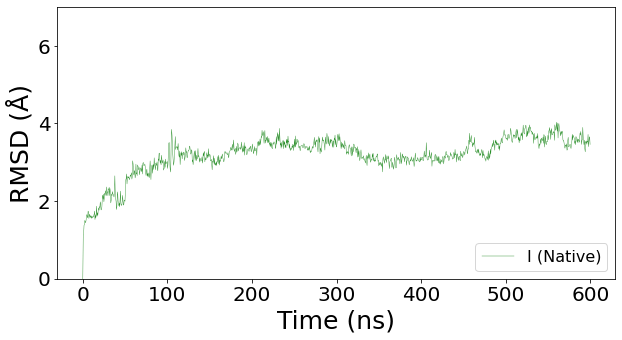

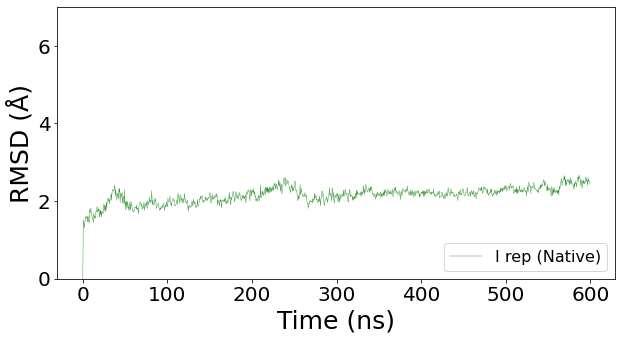

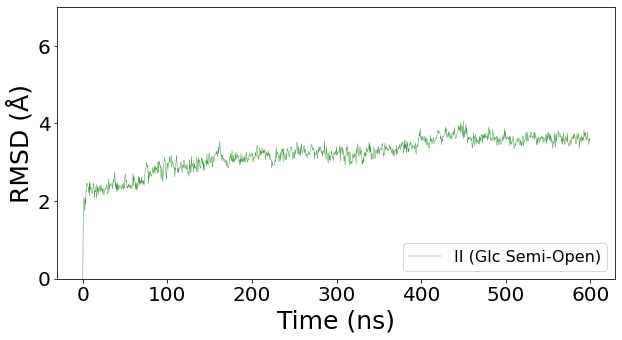

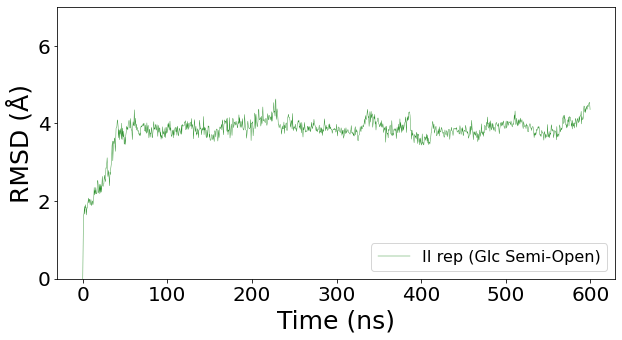

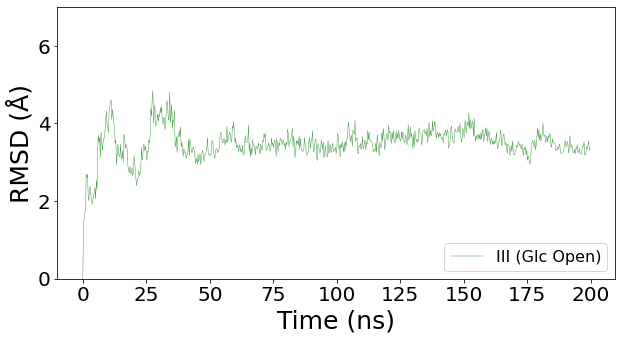

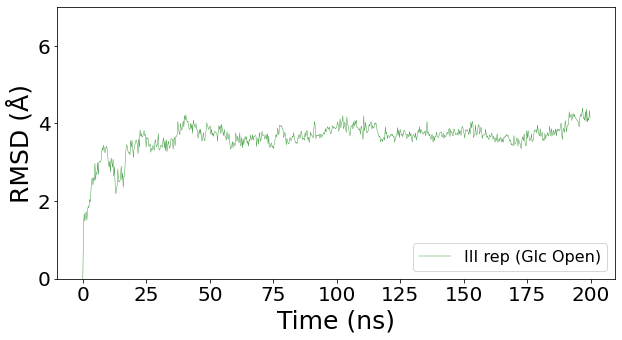

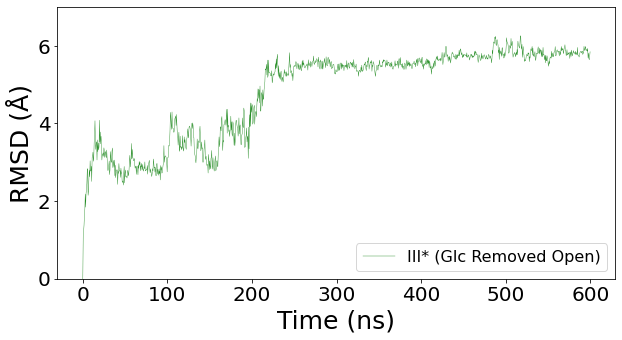

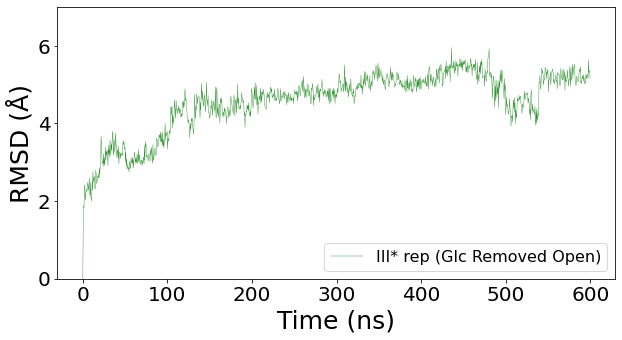

In [16]:
plt.rcParams['font.size']=20

plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_I) for a in range(len(rmsd_I))], rmsd_I, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 7)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['I (Native)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_I.png', bbox_inches='tight')

plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_I_rep) for a in range(len(rmsd_I_rep))], rmsd_I_rep, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 7)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['I rep (Native)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_I_rep.png', bbox_inches='tight')


plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_II) for a in range(len(rmsd_II))], rmsd_II, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 7)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['II (Glc Semi-Open)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_II.png', bbox_inches='tight')

plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_II_rep) for a in range(len(rmsd_II_rep))], rmsd_II_rep, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 7)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['II rep (Glc Semi-Open)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_II_rep.png', bbox_inches='tight')

plt.figure(figsize=(10,5))
plt.plot([200*a/len(rmsd_III) for a in range(len(rmsd_III))], rmsd_III, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 7)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['III (Glc Open)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_III.png', bbox_inches='tight')

plt.figure(figsize=(10,5))
plt.plot([200*a/len(rmsd_III_rep) for a in range(len(rmsd_III_rep))], rmsd_III_rep, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 7)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['III rep (Glc Open)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_III_rep.png', bbox_inches='tight')

plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_IV) for a in range(len(rmsd_IV))], rmsd_IV, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 7)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['III* (Glc Removed Open)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_IV.png', bbox_inches='tight')

plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_IV_rep) for a in range(len(rmsd_IV_rep))], rmsd_IV_rep, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 7)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['III* rep (Glc Removed Open)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_IV_rep.png', bbox_inches='tight')

## 2a. Substrate-loop (A352-CA) to N5 distance

In [17]:
# compute distance between S347-C and N5
Sloop_I = pt.distance(trajectory_I, ':348@CA :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Sloop_II = pt.distance(trajectory_II, ':348@CA :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Sloop_III = pt.distance(trajectory_III, ':348@CA :FAD@N5') #7523 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!
Sloop_IV = pt.distance(trajectory_IV, ':348@CA :FAD@N5') #7522 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!

#The N5 problem might have something to to with the fact that the FAD chain in the pdb file
#is diferent in II and IV (A12001; F in I and II). Tried to change it but the xtc file might also have been afected 

print(Sloop_I)
print(Sloop_II)
print(Sloop_III)
print(Sloop_IV)

[18.43390957 18.32656676 17.93945704 ... 19.48298582 18.57277271
 18.94886152]
[18.36386597 17.48070097 16.83030103 ... 15.68835897 15.32858666
 15.45080867]
[24.6952904  25.52415108 25.6722223  ... 32.14975596 30.31389588
 33.09746816]
[25.29587278 24.21359473 25.13724923 ... 17.68517981 16.90506098
 17.41346567]


In [18]:
# compute distance between S347-C and N5
Sloop_I_rep = pt.distance(trajectory_I_rep, ':348@CA :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Sloop_II_rep = pt.distance(trajectory_II_rep, ':348@CA :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Sloop_III_rep = pt.distance(trajectory_III_rep, ':348@CA :FAD@N5') #7523 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!
Sloop_IV_rep = pt.distance(trajectory_IV_rep, ':348@CA :FAD@N5') #7522 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!

#The N5 problem might have something to to with the fact that the FAD chain in the pdb file
#is diferent in II and IV (A12001; F in I and II). Tried to change it but the xtc file might also have been afected 

print(Sloop_I_rep)
print(Sloop_II_rep)
print(Sloop_III_rep)
print(Sloop_IV_rep)

[17.76549933 17.98849761 17.98128165 ... 16.61804538 17.24113496
 16.15164018]
[18.88442981 19.66266511 20.15104114 ... 25.0160831  24.42580421
 25.24072813]
[26.20841557 28.39943858 28.02764585 ... 32.73787433 33.34901454
 31.97000652]
[27.02850996 26.68917241 26.09415443 ... 34.818351   32.39071542
 32.70776583]


In [19]:
DISTANCE_LOOP_PLOT_FILENAME = './AsP2Ox_DistSubLoop.png' #Output filename for the plot
DISTANCE_LOOP_DATA_FILE = "./AsP2Ox_DistSubLoop.txt" #Text file to store data

#DISTANCE_LOOP_COLOR = 'red' #Color of the line
MAX_DISTANCE_LOOP = math.ceil(10*Sloop_I.max()) #It can be modified if you want to change the scale of the plot. If xtc.
MIN_DISTANCE_LOOP = math.ceil(10*Sloop_I.min()) #For use in PCA plot. If xtc, as before.

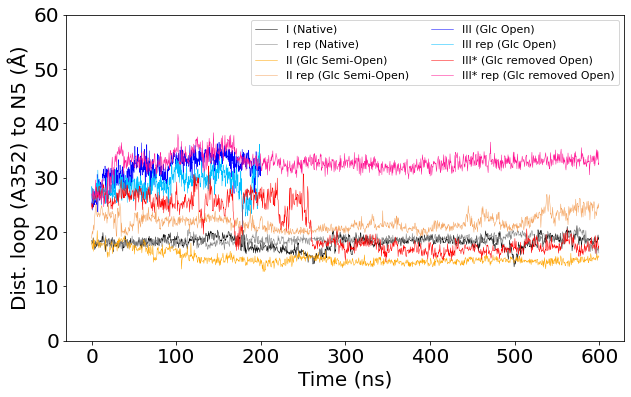

In [20]:
plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))
plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_I) for a in range(len(Sloop_I))], 
         Sloop_I, linewidth=0.5, color='black', label="I (Native)") #If xtc as units are nm (remove *10 if not)

plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_I_rep) for a in range(len(Sloop_I_rep))], 
         Sloop_I_rep, linewidth=0.5, color='grey', label="I rep (Native)") #If xtc as units are nm (remove *10 if not)

plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_II) for a in range(len(Sloop_II))], 
         Sloop_II, linewidth=0.5, color='orange', label="II (Glc Semi-Open)") #If xtc as units are nm (remove *10 if not)

plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_II_rep) for a in range(len(Sloop_II_rep))], 
         Sloop_II_rep, linewidth=0.5, color='sandybrown', label="II rep (Glc Semi-Open)") #If xtc as units are nm (remove *10 if not)

plt.plot([200*a/len(Sloop_III) for a in range(len(Sloop_III))], 
         Sloop_III, linewidth=0.5, color='blue', label="III (Glc Open)") #If xtc as units are nm (remove *10 if not)

plt.plot([200*a/len(Sloop_III_rep) for a in range(len(Sloop_III_rep))], 
         Sloop_III_rep, linewidth=0.5, color='deepskyblue', label="III rep (Glc Open)") #If xtc as units are nm (remove *10 if not)


plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_IV) for a in range(len(Sloop_IV))], 
         Sloop_IV, linewidth=0.5, color='red', label="III* (Glc removed Open)") #If xtc as units are nm (remove *10 if not)

plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_IV_rep) for a in range(len(Sloop_IV_rep))], 
         Sloop_IV_rep, linewidth=0.5, color='deeppink', label="III* rep (Glc removed Open)") #If xtc as units are nm (remove *10 if not)

plt.ylim(0, 60)
plt.xlabel('Time (ns)')
plt.ylabel(u'Dist. loop (A352) to N5 (Å)')
plt.legend(fontsize=11, bbox_to_anchor =(1, 1), ncol = 2)

plt.savefig(DISTANCE_LOOP_PLOT_FILENAME, bbox_inches='tight')
plt.show()

#And write the data into a text file
with open(DISTANCE_LOOP_DATA_FILE, "w") as f:
    for a, r in enumerate(Sloop_I):
        f.write("%f\t%f\n" %(TRAJECTORY_LENGTH*a/len(Sloop_I), r*10))  #If xtc read has units of nm (remove *10 if not)

## Tried to smooth the line:
### (ignore, at least for now)

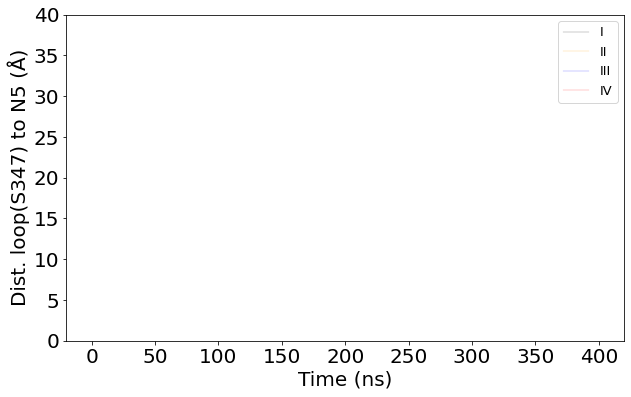

In [21]:
from scipy.interpolate import make_interp_spline

plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))
xI=[TRAJECTORY_LENGTH*a/len(Sloop_I) for a in range(len(Sloop_I))]
yI=10*Sloop_I
X_Y_Spline = make_interp_spline(xI, yI)
x_I = np.linspace(0, 400, 500)
y_I = X_Y_Spline(x_I)
plt.plot(x_I, y_I, linewidth=0.2, color='black') #If xtc as units are nm (remove *10 if not)


xII=[TRAJECTORY_LENGTH*a/len(Sloop_II) for a in range(len(Sloop_II))]
yII=10*Sloop_II
X_Y_Spline = make_interp_spline(xII, yII)
x_II = np.linspace(0, 400, 500)
y_II = X_Y_Spline(x_II)
plt.plot(x_II, y_II, linewidth=0.2, color='orange') #If xtc as units are nm (remove *10 if not)


xIII=[TRAJECTORY_LENGTH*a/len(Sloop_III) for a in range(len(Sloop_III))]
yIII=10*Sloop_III
X_Y_Spline = make_interp_spline(xIII, yIII)
x_III = np.linspace(0, 400, 500)
y_III = X_Y_Spline(x_III)
plt.plot(x_III, y_III, linewidth=0.2, color='blue') #If xtc as units are nm (remove *10 if not)


xIV=[TRAJECTORY_LENGTH*a/len(Sloop_IV) for a in range(len(Sloop_IV))]
yIV=10*Sloop_IV
X_Y_Spline = make_interp_spline(xIV, yIV)
x_IV = np.linspace(0, 400, 500)
y_IV = X_Y_Spline(x_IV)
plt.plot(x_IV, y_IV, linewidth=0.2, color='red') #If xtc as units are nm (remove *10 if not)

plt.ylim(0, 40)
plt.xlabel('Time (ns)')
plt.ylabel(u'Dist. loop(S347) to N5 (Å)')
#plt.savefig('Sloop_smoothish', bbox_inches='tight')

plt.legend(['I', 'II', 'III', 'IV'],fontsize=13)



## 2b. Insertion (G84-CA) to N5 distance

In [15]:
# compute distance between P83-CG and N5

Glc_II = pt.distance(trajectory_II, ':510@C2 :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Glc_III = pt.distance(trajectory_III, ':508@C2 :FAD@N5') #7523 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!




print(Glc_II)
print(Glc_III)


[3.91457671 3.79006843 3.51339767 ... 3.76019421 4.12025659 3.55679866]
[ 4.6584015   4.51497526  4.70136675 ... 22.59379381 23.06356849
 36.11047953]


In [16]:
# compute distance between P83-CG and N5

Glc_II_rep = pt.distance(trajectory_II_rep, ':510@C2 :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Glc_III_rep = pt.distance(trajectory_III_rep, ':508@C2 :FAD@N5') #7523 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!



print(Glc_II_rep)
print(Glc_III_rep)


[ 3.60275597  3.32527944  3.57310402 ... 18.59560505 18.60242306
 16.75140629]
[ 5.12113238  5.83823184  5.08264067 ... 56.00951034 47.15960609
 48.78319017]


In [19]:
Glc_list = ['Glc_II','Glc_II_rep','Glc_III','Glc_III_rep']
Glc_table = pd.DataFrame([Glc_II, Glc_II_rep, Glc_III, Glc_III_rep],
                                    index = Glc_list)
Glc_table = Glc_table.transpose()

Glc_table.to_csv('./csvfiles//GaMD_Glc_all.csv')
Glc_table

,Glc_II,Glc_II_rep,Glc_III,Glc_III_rep
0,3.914577,3.602756,4.658401,5.121132
1,3.790068,3.325279,4.514975,5.838232
2,3.513398,3.573104,4.701367,5.082641
3,3.564601,3.372658,4.924590,5.428830
4,3.312052,4.158357,4.650680,6.244716
...,...,...,...,...
1247,3.799525,17.687158,NaN,NaN
1248,3.505343,18.349420,NaN,NaN
1249,3.760194,18.595605,NaN,NaN
1250,4.120257,18.602423,NaN,NaN


In [39]:
DISTANCE_GLC_FAD_FILENAME = './AsP2Ox_DistGlc.png' #Output filename for the plot
DISTANCE_INSERTION_DATA_FILE = "./AsP2Ox_DistInsertion.txt" #Text file to store data

#DISTANCE_INSERTION_COLOR = 'red' #Color of the line
MAX_DISTANCE_INSERTION = math.ceil(10*Iloop_I.max()) #It can be modified if you want to change the scale of the plot. If xtc.
MIN_DISTANCE_INSERTION = math.ceil(10*Iloop_I.min()) #For use in PCA plot. If xtc, as before.


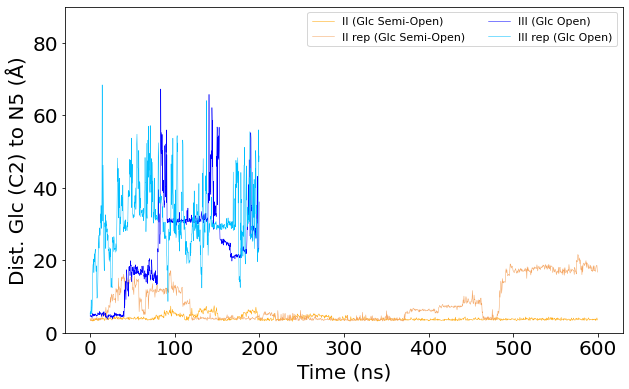

In [43]:
plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))
plt.plot([TRAJECTORY_LENGTH*a/len(Glc_II) for a in range(len(Glc_II))], 
         Glc_II, linewidth=0.5, color='orange', label="II (Glc Semi-Open)") #If xtc as units are nm (remove *10 if not)

plt.plot([TRAJECTORY_LENGTH*a/len(Glc_II_rep) for a in range(len(Glc_II_rep))], 
         Glc_II_rep, linewidth=0.5, color='sandybrown', label="II rep (Glc Semi-Open)") #If xtc as units are nm (remove *10 if not)


plt.plot([200*a/len(Glc_III) for a in range(len(Glc_III))], 
         Glc_III, linewidth=0.5, color='blue', label='III (Glc Open)') #If xtc as units are nm (remove *10 if not)

plt.plot([200*a/len(Glc_III_rep) for a in range(len(Glc_III_rep))], 
         Glc_III_rep, linewidth=0.5, color='deepskyblue', label='III rep (Glc Open)') #If xtc as units are nm (remove *10 if not)


plt.ylim(0, 90)
plt.xlabel('Time (ns)')
plt.ylabel(u'Dist. Glc (C2) to N5 (Å)')
plt.legend(fontsize=11, bbox_to_anchor =(1, 1), ncol = 2)
plt.savefig(DISTANCE_GLC_FAD_FILENAME, bbox_inches='tight')
plt.show()


#And write the data into a text file
with open(DISTANCE_INSERTION_DATA_FILE, "w") as f:
    for a, r in enumerate(Iloop_I):
        f.write("%f\t%f\n" %(TRAJECTORY_LENGTH*a/len(Iloop_I), r*10))  #If xtc read has units of nm (remove *10 if not)